In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from derivGP import JaxDerviativeGP

In [2]:
n  = 20
pn = 50

x = np.random.rand(n)

y = np.exp(-x*2)*np.sin(x*2.*np.pi)

px = np.linspace(0,1,pn)
py = np.exp(-px*2)*np.sin(px*2.*np.pi)

# JaxDerivativeGP
### A class for using a Gaussian process to estimate an unknown function and do prediction with uncertainty on the function's derivatives

- Code mostly thrown together this weekend, so please double check results at first. I will continue to test more but this code is very much a work in progress

- Because of that, there is a chance that function calls, syntax, or naming is changed over time (I will almost certainly try to name this something less clunky)

- Currently designed to train a GP on observations of a function (noise term not learned yet, can easily add if desired. "Nugget" is a settable attribute of the class that defaults to 1.e-4

- Right now, the code is not set up to train on observations of any of the process derivatives, only learn on observations of the function and predict, with uncertainty, derivatives of the function. If you would like the ability to train on observations of derivatives, that's very doable but might take a little time.

## Mike's To Do:

- Right now the GP is isotropic for 2D (same correlation length in each direction). It would be good to have two correlation length parameters, but my first attempt really slowed down the code for some reason. It will be important to allow though

- Allow user to learn nugget term rather than fix is at 1.e-4 (or set it by setting jgp.nugget = value)

- Allow for observations of derivatives

- Better than (3), set up functions to easily generate relavent covariance matrices of derivatives. This should allow this to plug into NumPyro nicely so that user can write their model in NumPyro and do their inference more generally.

- More general 2D derivative structure -- predict mixed derivatives like d2f/dxdy

- Things Chrisitian or others request.

In [3]:
jgp = JaxDerviativeGP(x,y)
jgp.train()

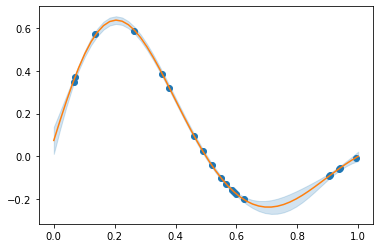

In [4]:
y_hat, _, upper, lower = jgp.predict(px)

plt.scatter(x, y,c="C0")
plt.plot(px, y_hat, c="C1")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()



## For prediction of derivatives with 1D GP:

- df/dx gives first derivative
- Higher derivatives checked by looking for int on last character
- so d2f/dx2 will give second derivative, as will df/dx2
- df/dx1 I think will give the same result as df/dx
- Cannot go higher than 9th derivative - computational cost will be impractical anyway, but also d10f/dx10 would get parsed as the 0th derivative because I'm currently looking only at the trailing int.
- 0th derivatives wont be properly processed either. Just leave derivative as None for predicting function values. 

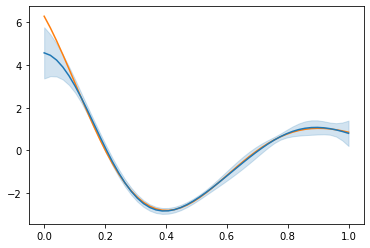

In [5]:
y_hat, _, upper, lower = jgp.predict(px, derivative="df/dx")

plt.plot(px, -2*np.exp(-2*px)*np.sin(px*2.*np.pi) + np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi, c="C1")
plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()


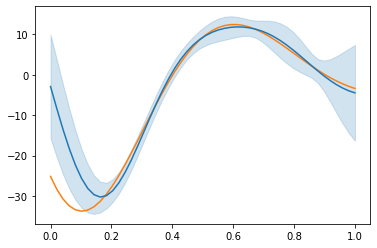

In [6]:
y_hat, _, upper, lower = jgp.predict(px, derivative="d2f/dx2")

plt.plot(px, 4*np.exp(-2*px)*np.sin(px*2.*np.pi) + 
         -4*np.pi*np.exp(-2*px)*np.cos(px*2.*np.pi) + 
         -2*np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi - 
         np.exp(-2*px)*np.sin(px*2.*np.pi)*4*np.pi**2, c="C1")
plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()

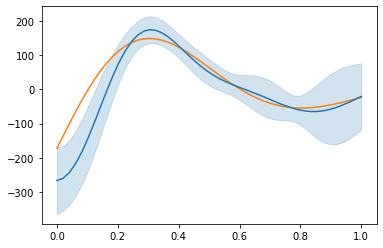

In [7]:
y_hat, _, upper, lower = jgp.predict(px, derivative="d3f/dx3")

plt.plot(px, -8*np.exp(-2*px)*np.sin(px*2.*np.pi) +
         8*np.pi*np.exp(-2*px)*np.cos(px*2.*np.pi) +
         8*np.pi*np.exp(-2*px)*np.cos(px*2.*np.pi) + 
         8*np.pi**2*np.exp(-2*px)*np.sin(px*2.*np.pi) + 
         4*np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi +
         2*np.exp(-2*px)*np.sin(px*2.*np.pi)*4*np.pi**2 + 
         2*np.exp(-2*px)*np.sin(px*2.*np.pi)*4*np.pi**2 +
         -np.exp(-2*px)*np.cos(px*2.*np.pi)*8*np.pi**3, c="C1")
plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()

In [8]:
def truef(x):
    return np.sin(x[:,0]*2 *np.pi) + x[:,1]

def truedfdx(x):
    #return -np.sin(x[:,0]*2 *np.pi)*4 *np.pi**2
    return np.cos(x[:,0]*2 *np.pi)*2 *np.pi

def truedfdy(x):
    #return 1.*np.zeros_like(x[:,0])
    return 1.*np.ones_like(x[:,0])


In [9]:
n  = 30
pn = 400

x  = np.random.rand(n,2)
px = np.array([(x, y) for x in np.linspace(0,1,20) for y in np.linspace(0,1,20)])
y  = truef(x)


In [11]:
jgp = JaxDerviativeGP(x,y)


In [12]:
jgp.train()

In [13]:
py   = truef(px)

vmin = np.min(py)
vmax = np.max(py)

y_hat, _, upper, lower = jgp.predict(px)

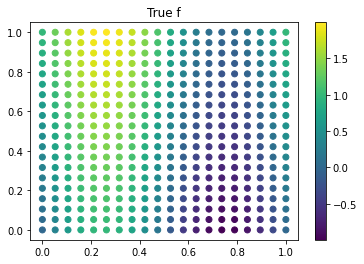

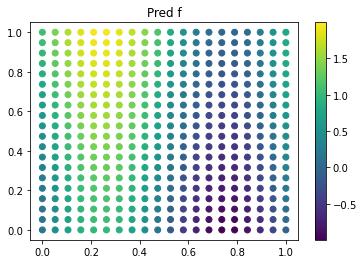

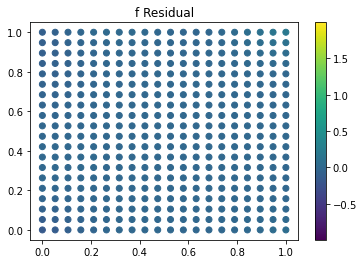

In [14]:
plt.scatter(px[:, 0], px[:, 1], c=py, vmin=vmin, vmax=vmax)
plt.title("True f")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=y_hat, vmin=vmin, vmax=vmax)
plt.title("Pred f")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=py - y_hat, vmin=vmin, vmax=vmax)
plt.title("f Residual")
plt.colorbar()
plt.show()


## For prediction of derivatives with 2D GP:

- df/dx, df/dy gives first derivative in x and y direction respectively
- As with 1D, higher derivatives checked by looking for int on last character
- Right now the implementation wont give mixed derivatives (e.g. ddf/dxdy or d3f/dx2dy, etc). This is mostly a bookkeeping thing with my code and should be do-able. If this is critical I can implement it sooner. 

Other cavaets on the 1D GP apply here

In [15]:
py   = truedfdx(px)

vmin = np.min(py)
vmax = np.max(py)

y_hat, _, upper, lower = jgp.predict(px, derivative="df/dx")

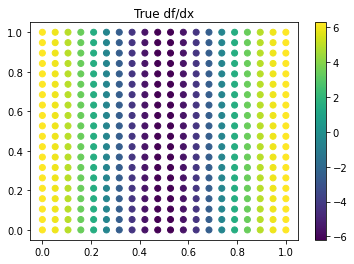

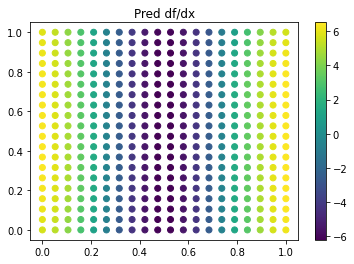

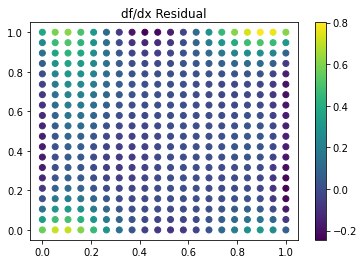

In [16]:
plt.scatter(px[:, 0], px[:, 1], c=py)
plt.title("True df/dx")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=y_hat)
plt.title("Pred df/dx")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c= py - y_hat)
plt.title("df/dx Residual")
plt.colorbar()
plt.show()


In [17]:
py   = truedfdy(px)

vmin = np.min(py)
vmax = np.max(py)

y_hat, _, upper, lower = jgp.predict(px, derivative="df/dy")

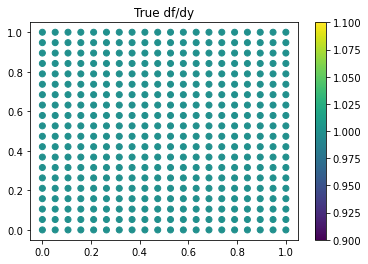

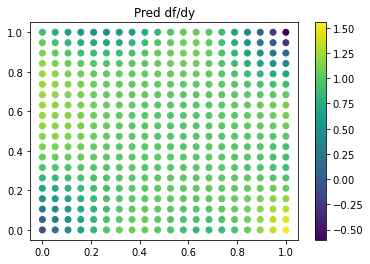

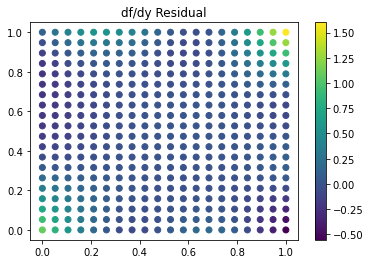

In [18]:
plt.scatter(px[:, 0], px[:, 1], c=py)
plt.title("True df/dy")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=y_hat)
plt.title("Pred df/dy")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=py - y_hat)
plt.title("df/dy Residual")
plt.colorbar()
plt.show()
